# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# import psycopg2
# from psycopg2 import sql, extras

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd

# Get CWD

cwd = os.getcwd() # This is a global variable for where the notebook is (must change if running in arcpro)

In [2]:
### Definitions

def extract_zip_from_url(url=None, path=None):
    '''Extract a zipfile from the internet
    then unpack it in to it's own folder 
    within the working directory.
    Takes a single url (string).'''

    if not os.path.exists(path):
        os.mkdir(path)
    # Unload zip into the new folder
    response = urllib.request.urlopen(url) # Get a response
    zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
    zip_folder.extractall(path=path) # Extract files
    zip_folder.close() # Close zip object

In [3]:
### Download
    
## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/shp_trans_aadt_traffic_segments.zip'

# Create folder name for file
folder_name = url.split('/')[-1][:-4]
# Make folder for files
savepath = os.path.join(cwd, '..','..','Data', folder_name)

extract_zip_from_url(url, savepath)

In [7]:
# Load Data

# AADT

filename = 'Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp'
path = os.path.join(savepath, filename)

aadt_mn = gpd.read_file(path)

# Minneapolis Boundary

filename = 'mpls_boundary.geojson'
path = os.path.join('..', '..', 'Data', filename)

mpls_boundary = gpd.read_file(path)

/home/robb/miniconda3/envs/gis5571/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

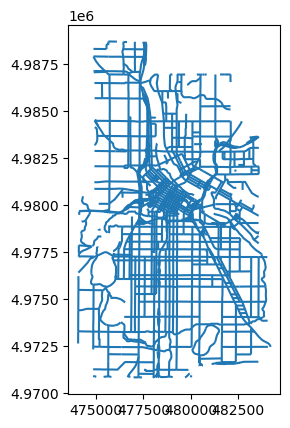

In [8]:
# Clip to extent
    
clipped_aadt = gpd.clip(aadt_mn, mpls_boundary)

clipped_aadt.plot()

In [9]:
# Save

clipped_aadt.to_file(os.path.join('..', '..', 'Data', 'mpls_aadt.geojson'))

In [48]:
# Upload to Database (NOT DONE, CHANGE THIS!)

# Get credentials

cred_pth = os.path.join(os.getcwd(), '..', '..', 'database', 'db_credentials.txt')

with open(cred_pth, 'r') as f:
    
    creds = f.readlines()[0].rstrip('\n').split(', ')
    
# Connect to PostGIS Database

pg_connection_dict = dict(zip(['dbname', 'user', 'password', 'port', 'host'], creds))

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

cols_for_arc = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM',
                'DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO',
                'CURRENT_YE','CURRENT_VO', 'SHAPE@WKT']

cols_for_dataframe = ['SEQUENCE_NUMBER','ROUTE_LABEL','STREET_NAME',
                      'DAILY_FACTOR', 'SEASONAL_FACTOR', 'AXLE_FACTOR',
                      'CURRENT_YEAR','CURRENT_VOLUME', 'geometry']

cols_for_dataframe = [col.lower() for col in cols_for_dataframe] # Must lowercase our columns...


cursor = arcpy.da.SearchCursor(clipped_aadt, cols_for_arc)

for row in cursor:
    
    # This is really a great way to insert a lot of data
    
    q1 = sql.SQL('INSERT INTO MNDOT_Current_AADT_Segments ({}) VALUES ({},{});').format(
     sql.SQL(', ').join(map(sql.Identifier, cols_for_dataframe)),
     sql.SQL(', ').join(sql.Placeholder() * (len(cols_for_dataframe)-1)),
     sql.SQL('ST_Transform(ST_SetSRID(ST_GeomFromText(%s), 26915),4326)::geometry'))
#     print(q1.as_string(conn))
#     break

    cur.execute(q1.as_string(conn),
        (row)
        )
    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()